# Случайные процессы. Прикладной поток.
## Практическое задание 6

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 6"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `6.N.ipynb` и `6.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline


### 1. Генерация винеровского процесса

Генерировать траектории винеровского процесса можно двумя способами:

1. На отрезке $[0, 1]$ траектория генерируется с помощью функций Шаудера. Описание данного метода было рассказано на лекции. Его можно найти так же в книге *А.В. Булинский, А.Н. Ширяев - Теория случайных процессов*.

2. На отрезке $[0, \pi]$ траекторию можно с помощью следующей формулы
$$W_t = \frac{\xi_0 t}{\sqrt{\pi}} +\sqrt{\frac{2}{\pi}}\sum\limits_{i=1}^{+\infty} \frac{\sin(kt)}{k} \xi_k,$$
где $\{\xi_n\}$ --- независимые стандартные нормальные случайные величины.

Траектория для $\mathbb{R}_+$ генерируется с помощью генерирования отдельных траекторий для отрезков длины 1 или $\pi$ (в зависимости от метода) с последующим непрерывным склеиванием.

Генерацию траекторий одним из этих способов вам нужно реализовать. Ваш вариант можете узнать из файла с распределением.

Напишите класс, который будет моделировать винеровский процесс.
Из бесконечной суммы берите первые $n$ слагаемых, где число $n$ соответствует параметру `precision`.
Интерфейс должен быть примерно таким (подчеркивания обязательны!):

## Для начала опишем модель генерации: <br>
 Сначала при первом вызове getitem для массива times сгенерируем винеровский процесс от $0$ до $k \pi$, где $k = \min ({p: p \pi < \max{times}})$. Обозначим верхнюю границу $board = k \pi$ (Изначально положим $board = 0$)<br>
При последующих вызовах getitem для массива times будем генерировать (при надобности) от последней верхней границы $board$ до нового $k \pi$, где $k = \min ({p: p \pi < \max{times}})$. После сдвигаем верхнюю границу: $board = k \pi$ <br>
Таким образом задача сводится к генерации процесса на отрезках вида $[i\pi, j\pi]$ для некоторых $i < j$ <br><br>
**Как генерировать винеровский процесс?** <br>
Мы умеем генерировать винеровский процесс только на отрезке $[0, \pi]$. <br>
Пусть нужно сгенерировать процесс на $[i\pi, j\pi]$, причем на отрезке $[0, i\pi]$ процесс уже был сгенерирован ранее. <br>
На отрезке $[i\pi, (i+1)\pi]$ генерируем следующим образом: $W_t = W_{i\pi} + \frac{\xi_0 t}{\sqrt{\pi}} +\sqrt{\frac{2}{\pi}}\sum\limits_{k=1}^{+\infty} \frac{\sin(kt)}{k} \xi_k$, где $t$ - время внутри интервала  (т.е. остаток от деления на $\pi$) <br>
Заметим также, что при такой генерации траектории полученного процесса будут непрерывными. <br>
Аналогичным образом генерируем процесс на отрезке $[(i+1)\pi, j\pi]$ и так далее.<br><br>

----

Также заметим, что в силу того, что getitem для одного и того же t должен возвращать одно и то же, то нам нужно запоминать генерацию на каждом отрезке вида $[i\pi, (i+1)\pi]$, а именно для каждого отрезка нужно хранить набор сгенерированных  нормально распределеннных величин $\{\xi^i_n\}$. <br> <br>

----
Для оптимальности решения поймем, что такое $W_{i\pi}$: <br>
$W_0 = 0$ <br>
$W_{\pi} = \frac{{\xi_0}^1 \pi}{\sqrt{\pi}}$ - первая генерация <br>
$W_{2\pi} = W_{\pi} + \frac{{\xi_0}^2 \pi}{\sqrt{\pi}} = \frac{({\xi_0}^1 + {\xi_0}^2) \pi}{\sqrt{\pi}}$ - вторая генерация <br>
и так далее. <br>
Таким образом: <br>
$$W_{k\pi} = \frac{(\sum_{i=1}^k {\xi_0}^i) \pi}{\sqrt{\pi}} = (\sum_{i=1}^k {\xi_0}^i) \sqrt\pi$$

In [30]:
class WinerProcess:
        
    def __init__(self, precision=10000):
        self.precision = precision
        
        #массив для хранения нормально распределенных величин (имеет размер (k, precision) для некоторого k)
        self.xi = []
        
        #генерируем отрезок [0,pi]
        self._init_generate()
        #ставим границу равную 1 (так как уже сгенерировали первый отрезок)
        self.board = 1
        
    def __getitem__(self, times):
        max_time = np.max(times)
        k = int((max_time // np.pi) + 1)
        
        #если нужно, генерируем
        if k > self.board:
            self._generate(k)
        
        #находим массив W_i_pi для разных i (массив значений в точках вида i*pi)
        W_i_pi = np.append(0, np.cumsum(self.xi[:,0]) * np.sqrt(np.pi))
        
        #номера интервалов и время внутри интервала (т.е. остаток от делениия на pi) для каждого times[i]
        intervals = np.array(times // np.pi, dtype=int)
        times_in_intervals = times % np.pi
        
        #коэфициенты по которым происходит сумирование во втором слагаемом
        grid = np.tile(np.arange(1, self.precision+1), (len(times), 1))
        
        #первое слагаемое
        first_term = self.xi[intervals,0] *  times_in_intervals / np.sqrt(np.pi)
        #второе слагаемое (большая сумма)
        second_term = np.sqrt(2/np.pi) * np.sum((np.sin(grid * times_in_intervals.reshape((len(times), 1))) / grid) * self.xi[intervals,1:], axis=1)
        
        result = W_i_pi[intervals] + second_term + first_term
        return result
        
        
    #метод, генерирующий процесс на отрезке [0, pi]
    def _init_generate(self):
        sample = sps.norm(loc=0, scale=1).rvs(size=(self.precision+1))
        self.xi.append(sample)
        self.xi = np.array(self.xi).reshape((1, self.precision+1))

    #метод, генерирующий процесс на отрезке [board*pi, k*pi]  
    def _generate(self, k):
        #кол-во отрезков, которые нужно сгенерировать
        count_intervals = k - self.board
        
        #генерирую случайные величины для всех count_intervals отрезков
        sample = sps.norm(loc=0, scale=1).rvs(size=(count_intervals, self.precision+1))
        self.xi = np.concatenate((self.xi, sample), axis=0)
        
        #сдвигаем границу
        self.board = k
        

* Экземпляр класса должен представлять некоторую траекторию винеровского процесса. Это означает, что один и тот же экземпляр класса для одного и того же момента времени должен возвращать одно и тоже значение. Разные экземпляры класса --- разные (п.н.) траектории.

* Метод `__init__` (конструктор) должен запоминать число слагаемых в сумме (`precision`), а также (может быть) генерировать необходимые случайные величины для начального отрезка.

* Метод `__getitem__` должен принимать набор моментов времени и возвращать значения траектории винеровского процесса в эти моменты времени. При необходимости можно сгенерировать новые случайные величины. Используйте то, что запись `x.__getitem__(y)` эквивалентна `x[y]`.

* Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`.

* Внимательно проверьте отсутствие разрывов траектории в точках, кратных $\pi$.

* Имена любых вспомогательных методов должны начинаться с одного подчеркивания.

* В реализации желательно комментировать (почти) каждую строку кода. Это даже больше поможет вам, чем нам при проверке.

Сгенерируйте траекторию винеровского процесса и постройте ее график. Сгенерируйте еще одну траекторию и постройте график двумерного винеровского процесса. Графики должны быть похожими на графики с семинара.

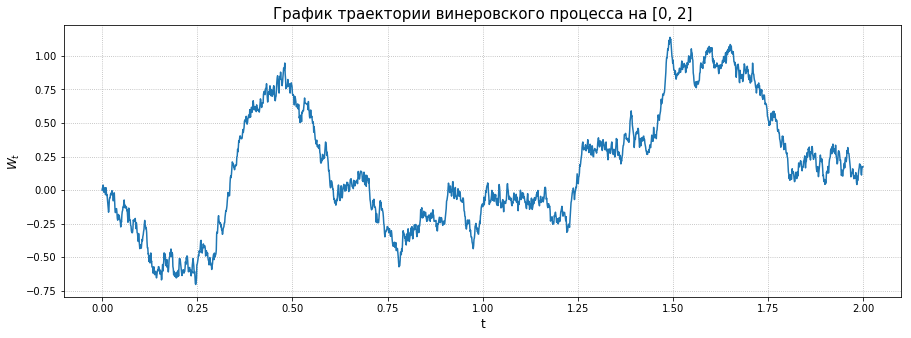

In [90]:
Wt = WinerProcess()
t = np.arange(0,2, 0.001)
values = Wt[t]

plt.figure(figsize=(15, 5))
plt.plot(t, values)
plt.grid(ls=':')
plt.xlabel('t', fontsize=12)
plt.ylabel('$W_t$', fontsize=12)
plt.title("График траектории винеровского процесса на [0, 2]", fontsize=15)
plt.show()

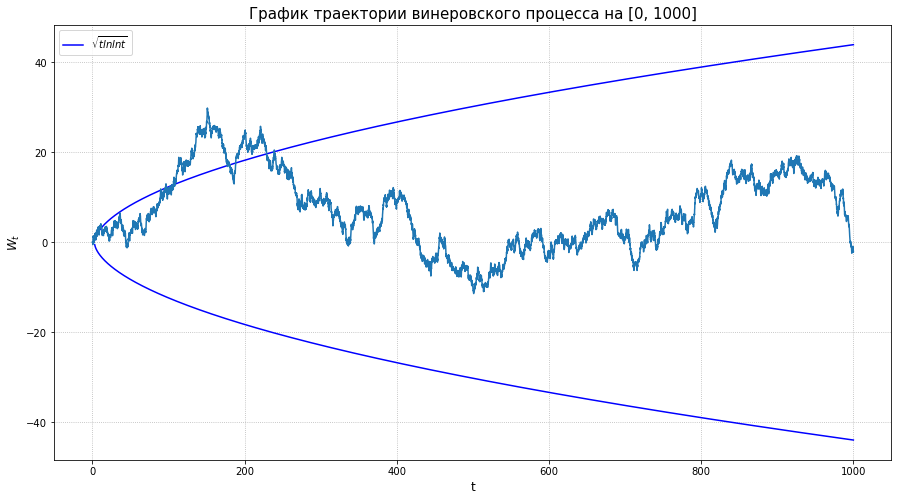

In [92]:
Wt = WinerProcess()
t = np.arange(0,1000, 0.1)
values = Wt[t]
grid = np.arange(3, 1000, 0.1)

plt.figure(figsize=(15, 8))
plt.plot(grid, np.sqrt(2 * grid * np.log(np.log(grid))), c='b', label='$\pm \sqrt {2t lnlnt}$')
plt.plot(grid, -np.sqrt(grid * np.log(np.log(grid))), c='b')
plt.plot(t, values)
plt.grid(ls=':')
plt.xlabel('t', fontsize=12)
plt.ylabel('$W_t$', fontsize=12)
plt.title("График траектории винеровского процесса на [0, 1000]", fontsize=15)
plt.legend()
plt.show()

Строим график траектории двумерного винеровского процесса

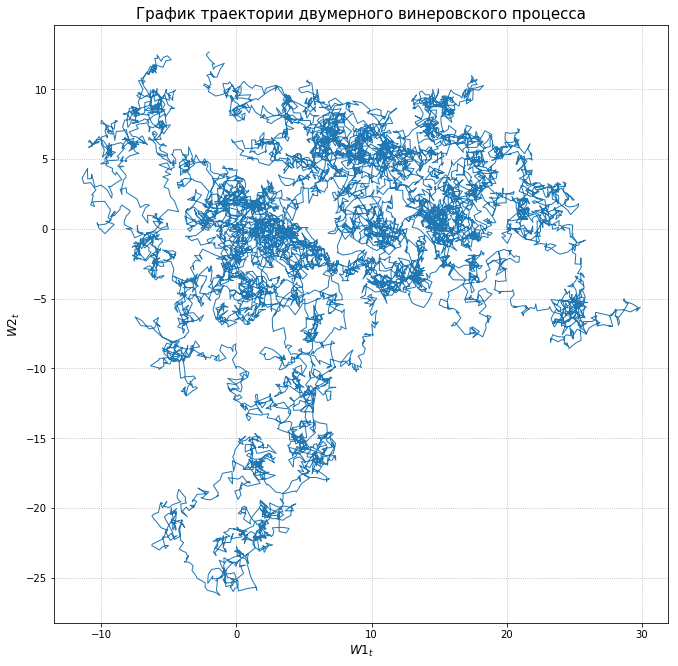

In [103]:
Wt2 = WinerProcess()
values2 = Wt2[t]

plt.figure(figsize=(11, 11))
plt.plot(values, values2, lw=1)
plt.grid(ls=':')
plt.xlabel('$W1_t$', fontsize=12)
plt.ylabel('$W2_t$', fontsize=12)
plt.title("График траектории двумерного винеровского процесса", fontsize=15)
plt.show()

Видим, график довольно похож на траекторию броуновского движения, то есть на траекторию хаотически движущейся частицы в пространстве. Как помним второе название винеровского процесса - процесс броуновского движения.

Допустим, для исследования свойств траекторий винеровского процесса нам нужно сгенерировать траекторию с хорошей точностью до достаточно большого значения $t$.
Какие проблемы могут возникнуть при использовании реализованного класса?
Для этого попробуйте запустить следующий код.

Опишите подробно причину проблемы, которая в данном случае возникает.

**Почему?** <br>
Если мы хотим иметь одну траекторию, то есть класс, который будет на одинаковые значения t возвращать одно и то же значение W_t, то нам обязательно нужно хранить параметры генерации на каждом из отрезков вида $[0, \pi]$. В данном случае эти параметры это выброка из стандартного нормального распределения размера (precision + 1) для каждого отрезка. Таким образом в каждый момент времени нам нужно хранить $k(precision + 1)$ случайных величин, где $k$ - кол-во уже сгенерированных отрезков. Таким образом,если время, до которого нам нужно сгенерировать процесс слишком велико, то мы просто не сможем хранить такое огромное кол-во информации. <br>
**Выход:** <br>
Не будем хранить хранить эти случайные величины. Это не позволит нам обращаться несколько раз к одной траектории, однако мы сможем единожды получить информацию о значения в интересующие нас моменты времени, чего в некоторых случаях достаточно.

Для избавления от таких проблем реализуйте следующую функцию:

In [142]:
def winer_process_path(end_time, step, precision=10000):
    # моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # вспомогательный массив, равный times, который будем изменять
    c_times = times.copy()
    
    # номер текущего отрезка
    k = 0
    
    # максимальное кол-во времен, которое может попасть в интервал вида [k*pi, (k+1) *pi]
    max_count = int(np.pi / step) + 2
    
    # массив значений в точках вида i*pi
    W_i_pi = [0]
    values = np.array([])
    
    #итерируемся по отрезкам
    while k*np.pi < end_time:
        xi = sps.norm(loc=0, scale=1).rvs(size=(precision+1))
        
        #находим времена, находящиеся в текущем отрезке [k*pi, (k+1) *pi]
        t = c_times[:max_count]
        times_in_interval = (t[t <= (k+1) * np.pi]) % np.pi
        
        grid = np.tile(np.arange(1, precision+1), (len(times_in_interval), 1))
        
        #первое слагаемое
        first_term =  xi[0] * times_in_interval / np.sqrt(np.pi)
        #второе слагаемое (большая сумма)
        second_term = np.sqrt(2/np.pi) * np.sum((np.sin(grid * times_in_interval.reshape((len(times_in_interval), 1))) / grid) * xi[1:], axis=1)
        
        result = W_i_pi[-1] + second_term + first_term
        values = np.append(values, result)
        
        #запоминаем значение в точке (k+1)*pi
        W_i_pi.append((xi[0] * np.sqrt(np.pi))  + W_i_pi[-1])
        k = k + 1
        c_times = c_times[len(times_in_interval):]

    return times, values

Построим график траектории винеровского процесса, полученного по новой функции

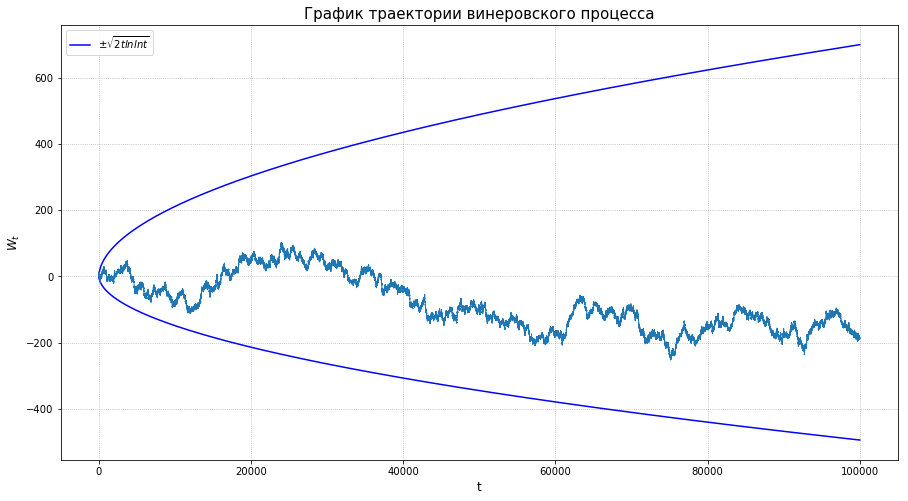

CPU times: user 4min 10s, sys: 21.8 s, total: 4min 32s
Wall time: 4min 34s


In [143]:
%%time

times, values = winer_process_path(100000, 0.1)
grid = np.arange(3, 100000, 0.1)

plt.figure(figsize=(15, 8))
plt.plot(grid, np.sqrt(2*grid * np.log(np.log(grid))), c='b', label='$\pm \sqrt {2t lnlnt}$')
plt.plot(grid, -np.sqrt(grid * np.log(np.log(grid))), c='b')
plt.plot(times, values, lw=1)
plt.grid(ls=':')
plt.xlabel('t', fontsize=12)
plt.ylabel('$W_t$', fontsize=12)
plt.title("График траектории винеровского процесса", fontsize=15)
plt.legend()
plt.show()

Полученный график похож на траекторию винеровского процесса (и также он находится в пределах кривых $\pm \sqrt {2t lnlnt}$)

Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`. Внутри этой функции можно реализовать вспомогательную функцию.

### 2. Исследования

**Следующая часть работы делается в паре.**

Для каждого их двух способов генерация траектрии винеровского процесса постройте таблицу $3 \times 3$ из графиков траекторий винеровского процесса.
По вертикали изменяйте количество $n$ используемых слагаемых в сумме ($n=10; 100; 1000$), по горизонтали --- длину отрезка, на котором генерируется винеровский процесс (использовать отрезки $[0, 10], [0, 1], [0, 0.1]$).
Обратите внимание, что от размера сетки зависит только точность отображения функции на графике, а не сама функция, поэтому сетку нужно выбирать достаточно мелкой.

Для красоты, после окончания сравнения двух разных генераций, код напарника был удален. (Романенко Илья - номер 22)

**Графики для генерации с помощью нормальных случайных величин**

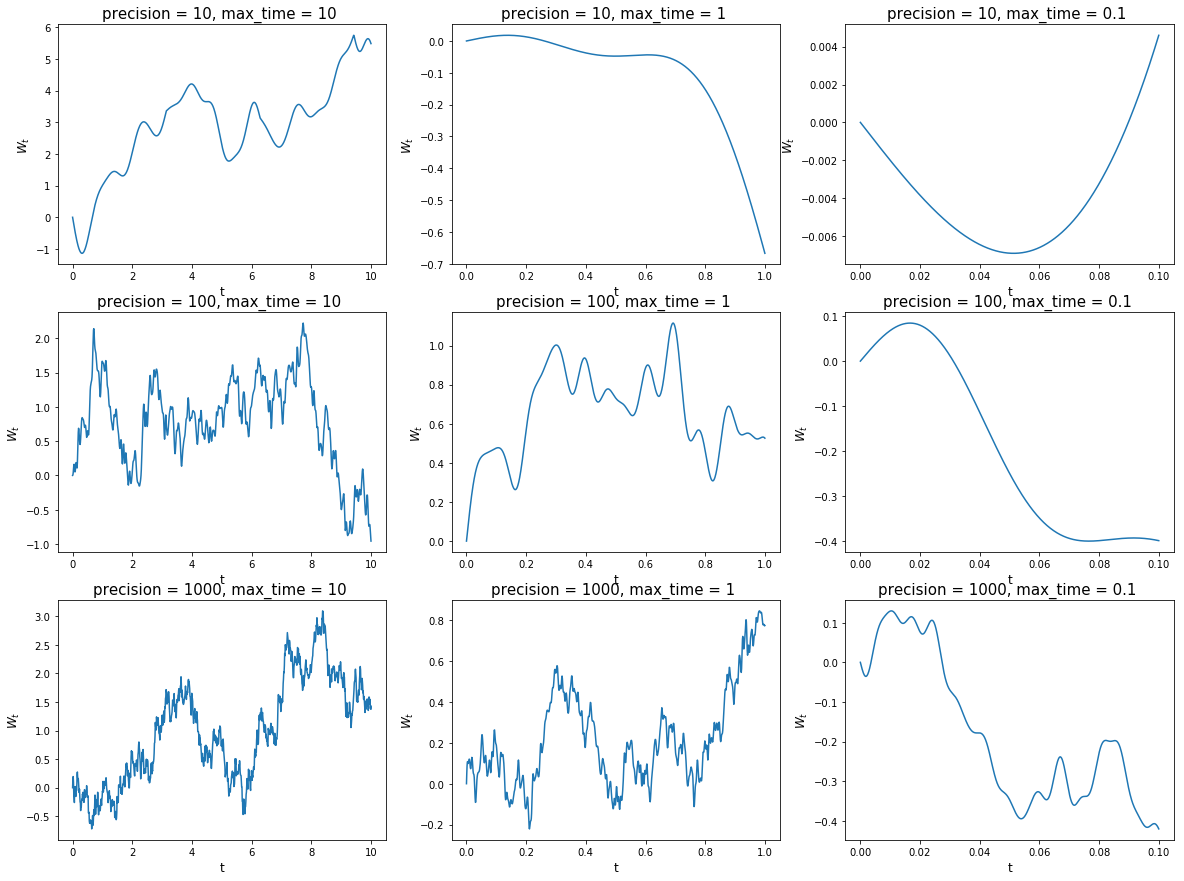

In [134]:
plt.figure(figsize=(20, 15))
for i, precision in enumerate([10, 100, 1000]):
    for j, max_time in enumerate([10, 1, 0.1]):
        t = np.linspace(0, max_time, 1000)
        values = WinerProcess(precision=precision)[t]
        
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(t, values)
        plt.title('precision = {}, max_time = {} '.format( precision, max_time), fontsize=15)
        plt.xlabel('t', fontsize=12)
        plt.ylabel('$W_t$', fontsize=12)
plt.show()

**Графики для генерации с помощью функций Шаудера **

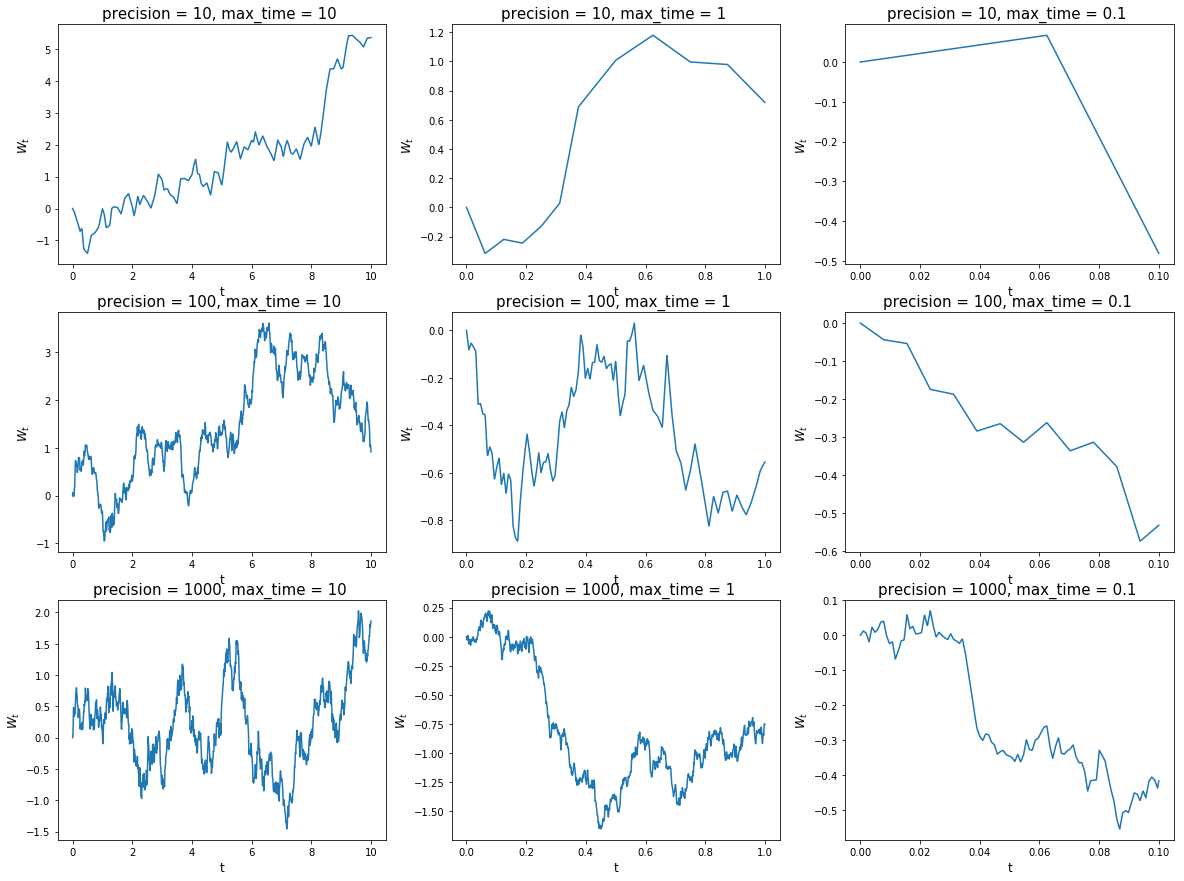

In [136]:
plt.figure(figsize=(20, 15))
for i, precision in enumerate([10, 100, 1000]):
    for j, max_time in enumerate([10, 1, 0.1]):
        t = np.linspace(0, max_time, 1000)
        values = WinerProcess_22(precision=precision)[t]
        
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(t, values)
        plt.title('precision = {}, max_time = {} '.format( precision, max_time), fontsize=15)
        plt.xlabel('t', fontsize=12)
        plt.ylabel('$W_t$', fontsize=12)
plt.show()

Какие выводы можно сделать про каждый способ генерации?

Заметная разница между траекториями - это гладкость(силней видна при рассмотрении небольшого интервала или небольшого precision). Траектории,найденные  через генерацию с нормальными с.в. гладкие в отличие от траектории через функции Шаудера. Это достаточно очевидно, так как во втором варианте мы используем синусы, которые являются гладкими функциями, а в первом - треугольники.

Сравните два способа генерации по времени работы.

**Генерация с помощью нормальных случайных величин.**

In [110]:
%time times, values = winer_process_path(100000, 0.1)

CPU times: user 3min 41s, sys: 27.2 s, total: 4min 8s
Wall time: 4min 8s


**Генерация с помощью функций Шаудера**

In [137]:
%time times, values = winer_process_path_22(100000, 0.1)

CPU times: user 52.5 s, sys: 924 ms, total: 53.4 s
Wall time: 54.7 s


Таким образом, видим, что генерация с помощью функции Шаудера работает намного быстрее генерации с помощью нормальных случайных величин, что логично так как асимптотика у данного алгоритма меньше.

Постройте графики полученных траекторий для каждого способа? Отличаются ли траектории визуально?

Какие можно сделать выводы из сравнения двух способов генерации?

**Генерация с помощью нормальных случайных величин**

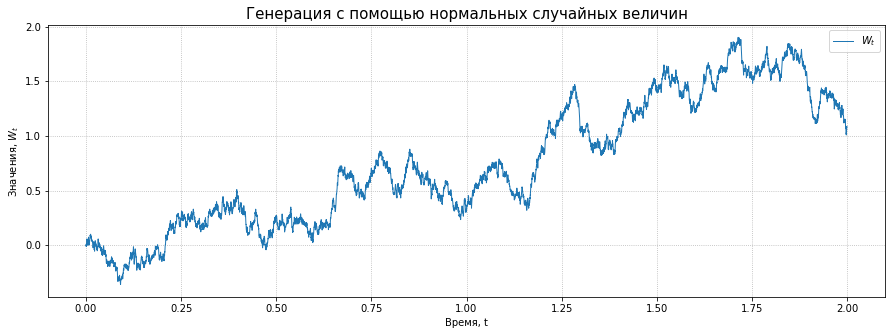

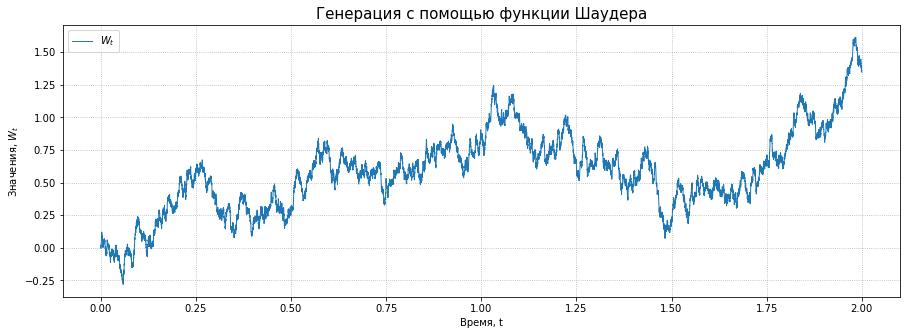

In [145]:
times, values = winer_process_path(2, 0.0001)

plt.figure(figsize=(15, 5))
plt.plot(times, values, lw=1, label='$W_t$')
plt.grid(ls=':')
plt.xlabel('Время, t')
plt.ylabel('Значения, $W_t$')
plt.title("Генерация с помощью нормальных случайных величин", fontsize=15)
plt.legend()
plt.show()

times, values = winer_process_path_22(2, 0.0001)

plt.figure(figsize=(15, 5))
plt.plot(times, values, lw=1, label='$W_t$')
plt.grid(ls=':')
plt.xlabel('Время, t')
plt.ylabel('Значения, $W_t$')
plt.title("Генерация с помощью функции Шаудера", fontsize=15)
plt.legend()
plt.show()

Обе траектории похожи на траекторию некоторого винеровского процесса. Причем внешне оба графика похожи (нет различий в гладкости и т.д.). То есть при рассмотрении большого precision и немаленького отрезка оба способа генерации нельзя внешне отличить друг от друга.

**Следующая часть работы делается индивидуально.**

1. Сгенерируйте 100 траекторий винеровского процесса с достаточно хорошей точностью и нарисуйте их на одном графике? Что можно сказать про поведение траекторий?

2. Нарисуйте график двумерного винеровского процесса (см. презентацию с семинара).

Рисуем 100 различных траекторий винеровского процесса.

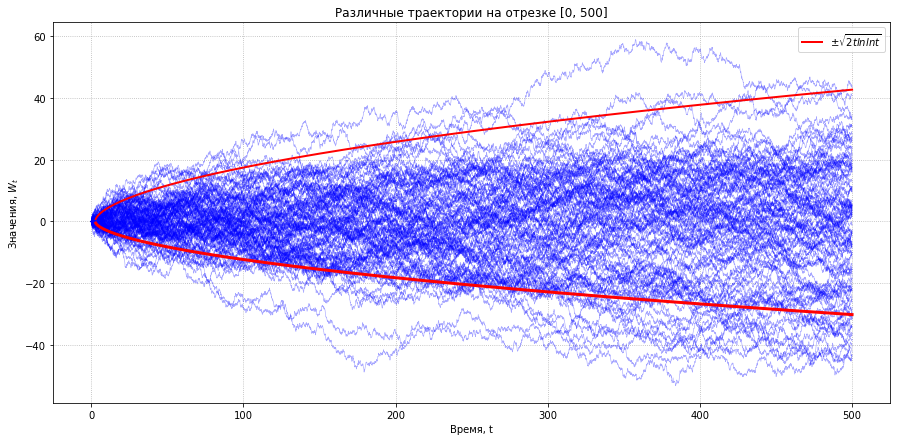

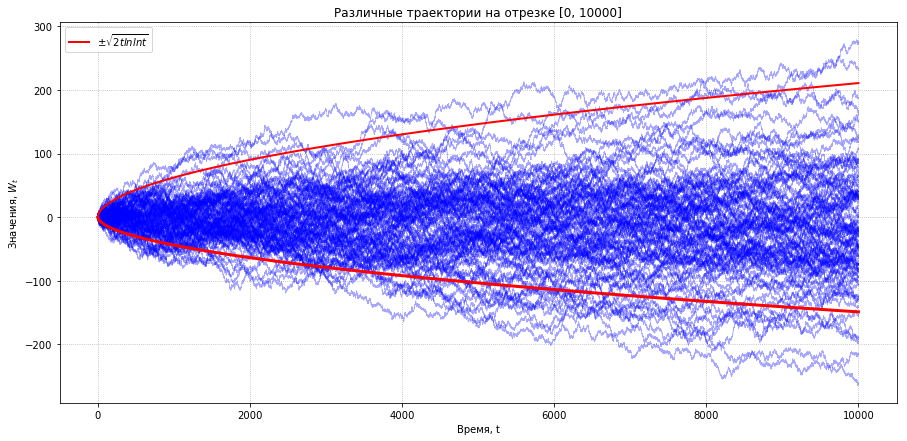

In [148]:
plt.figure(figsize=(15, 7))
for i in range(100):
    t, Wt = winer_proccess_path(500, 0.1)
    plt.plot(t, Wt, lw=0.6, alpha=0.35, c='b')

grid = np.arange(3, 500, 0.1)
plt.plot(grid, np.sqrt(2 * grid * np.log(np.log(grid))), c='r', label='$\pm\sqrt {2t lnlnt}$', lw=2)
plt.plot(grid, -np.sqrt(grid * np.log(np.log(grid))), c='r', lw=3)
plt.grid(ls=':')
plt.title('Различные траектории на отрезке [0, 500]')
plt.xlabel('Время, t')
plt.ylabel('Значения, $W_t$')
plt.legend()
plt.show()

plt.figure(figsize=(15, 7))
for i in range(100):
    t, Wt = winer_proccess_path(10000, 0.1)
    plt.plot(t, Wt, lw=0.6, alpha=0.35, c='b')

grid = np.arange(3, 10000, 0.1)
plt.plot(grid, np.sqrt(2 * grid * np.log(np.log(grid))), c='r', label='$\pm\sqrt {2t lnlnt}$', lw=2)
plt.plot(grid, -np.sqrt(grid * np.log(np.log(grid))), c='r', lw=3)
plt.grid(ls=':')
plt.title('Различные траектории на отрезке [0, 10000]')
plt.xlabel('Время, t')
plt.ylabel('Значения, $W_t$')
plt.legend()
plt.show()

Видим, что траектории в основном находятся в промежутке между кривыми $\pm \sqrt {2t lnlnt}$, однако каждая кривая иногда пересекает кривые $\pm \sqrt {2t lnlnt}$ (на самом деле траектория винеровского процесса задевает верхнюю и нижнюю кривые бесконечно много раз). Это вполне согласовывается с законом повторного логарифма, из которого следует, что размах отклонения от нуля во времени имеет порядок $ \sqrt {2t lnlnt}$.

Строим график двумерного винеровского процесса.

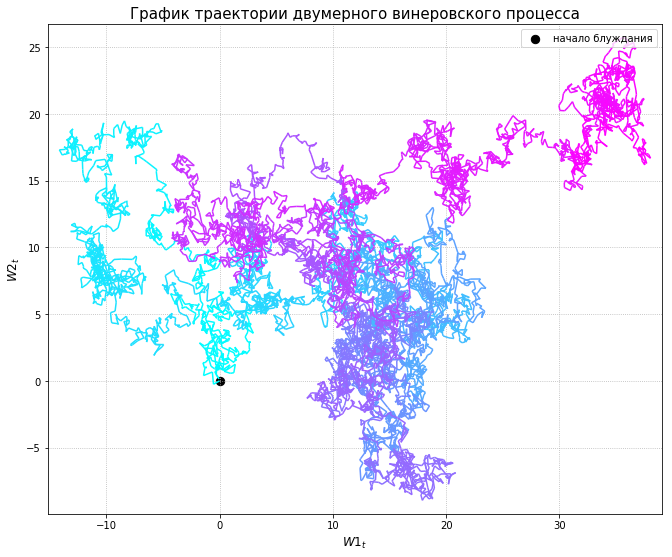

In [168]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

t1, Wt1 = winer_proccess_path(1000, 0.1)
t2, Wt2 = winer_proccess_path(1000, 0.1)

#Строим цветной график при помощи matplotlib.collections
points = np.array([Wt1, Wt2]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

lc = LineCollection(segments,cmap=plt.get_cmap('cool'))
lc.set_array(t1)

fig1 = plt.figure(figsize=(11, 9))
plt.gca().add_collection(lc)

plt.xlim((np.min(Wt1) - 1, np.max(Wt1) + 1))
plt.ylim((np.min(Wt2) - 1, np.max(Wt2) + 1))
plt.grid(ls=':')
plt.scatter(Wt1[0], Wt2[0], c='black', s=70, label='начало блуждания')
plt.xlabel('$W1_t$', fontsize=12)
plt.ylabel('$W2_t$', fontsize=12)
plt.title("График траектории двумерного винеровского процесса", fontsize=15)
plt.legend()
plt.show()

Из графика видно, что траектория непрерывна, но совсем не гладкая. Эти характеристики как раз соответствуют хаотическому (броуновскому) движению.

**Вывод:** <br>
Научились генерировать винеровский процесс при помощи случайных величин со стандартным нормальным распределением. <br> Сравнили 2 разных способа генерации: визуально на болших отрезках эти 2 способа неотличимы, однако генерация при помощи функции Шаудера работает быстрей. <br>
Убедились в справедливости закона повторного логарифма так как на графиках траектории имеют размах порядка $ \sqrt {2t lnlnt}$ <br>
Также нарисовали двумерный винеровский процесс и увидели, что он похож на траекторию случайного блуждания. <br> 